In [63]:

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import movingpandas as mpd
from datetime import datetime, timedelta
import contextily as cx
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler


from functools import partial
import pyproj
import shapely as shp
from matplotlib import pyplot as plt
from pymeos import *
from pymeos.plotters import TemporalPointSequencePlotter, TemporalSequencePlotter
from shapely.ops import transform
from tqdm.auto import tqdm
import plotly.express as px

tqdm.pandas()
pymeos_initialize()

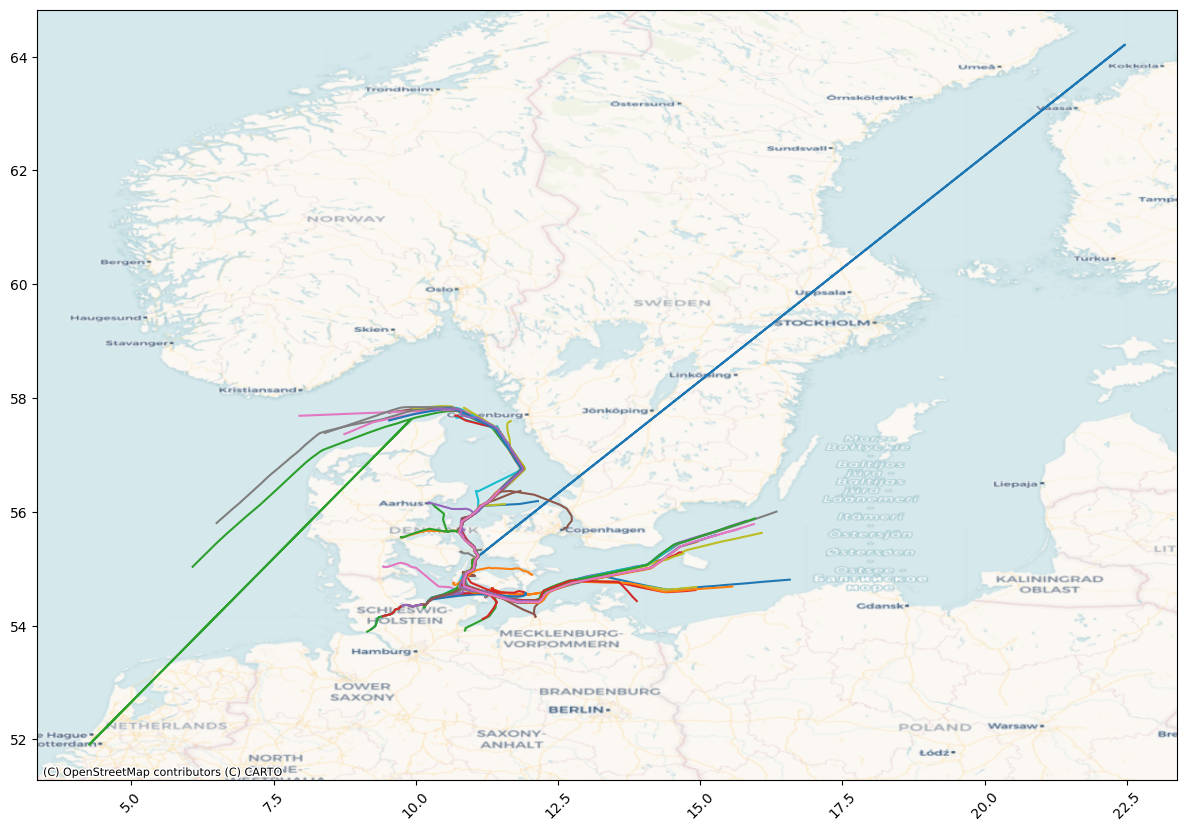

In [64]:
ships = pd.read_csv('Data/ships.csv', converters={
    'sog': TFloatSeq.from_hexwkb,
    'cog': TFloatSeq.from_hexwkb,
    'trip': partial(TGeomPointSeq.from_hexwkb, srid=25832)
})
_, ax = plt.subplots(figsize=(18, 10))
_ = TemporalPointSequencePlotter.plot_sequences_xy(ships['trip'], axes=ax, show_markers=False, show_grid=False)
_ = cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.Voyager)


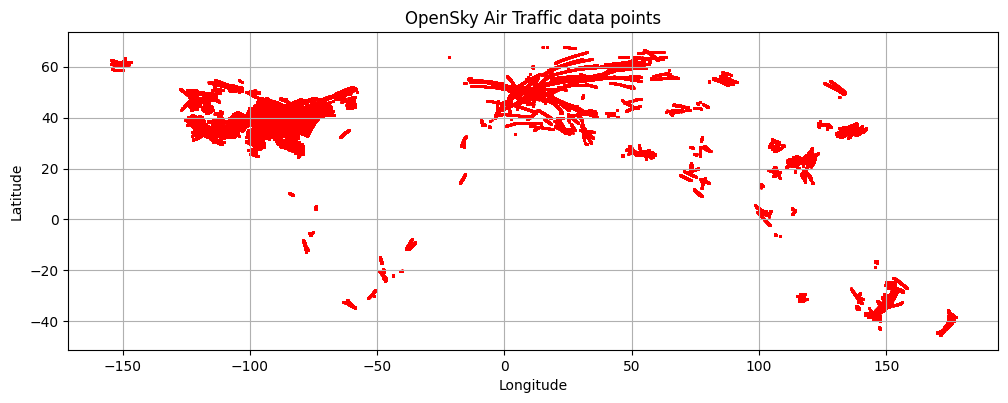

In [65]:

# Loading the dataset
df = pd.read_csv('Data/states_2020-05-25-00.csv')

# Converting to a GeoDataFrame
df['time'] = pd.to_datetime(df['time'])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

# Plotting the trajectories
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, markersize=1, color='red')
plt.title('OpenSky Air Traffic data points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


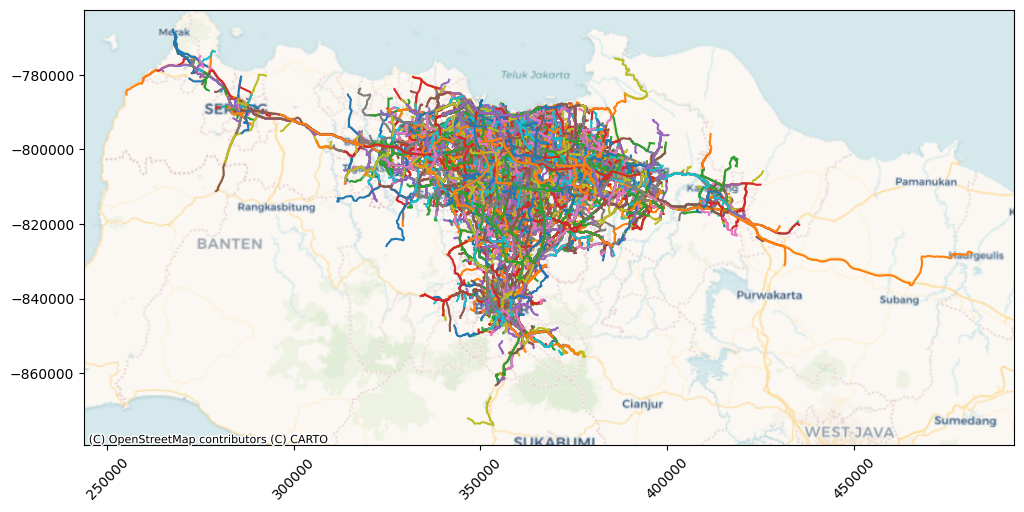

In [66]:
jakarta = pd.read_csv('Data/jakarta_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
_, ax = plt.subplots(figsize=(12, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(jakarta['Trajectory'], axes=ax, show_markers=False,
                                                   show_grid=False)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)


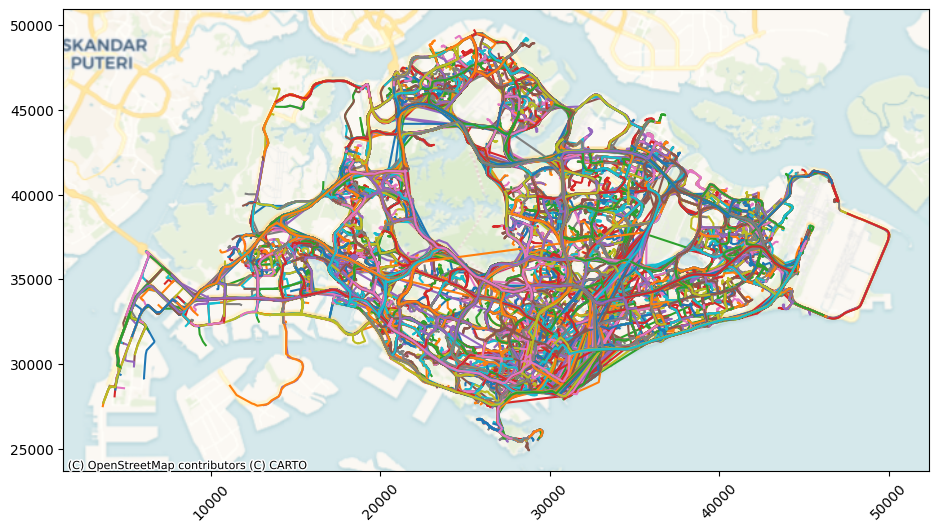

In [67]:
trajectories = pd.read_csv('Data/singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
_, ax = plt.subplots(figsize=(12, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(trajectories['Trajectory'], axes=ax, show_markers=False,
                                                   show_grid=False)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)

In [70]:

# Load your AIS dataset
ais_df = pd.read_csv('Data/aisSmall.csv')
ais_df['Timestamp'] = pd.to_datetime(ais_df['Timestamp'])

# Creating an interactive plot with Plotly
fig = px.scatter_geo(ais_df, 
                     lat='Latitude', 
                     lon='Longitude', 
                     color='SOG', 
                     hover_name='MMSI', 
                     animation_frame=ais_df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S'),
                     projection='natural earth')

# Update layout
fig.update_layout(title='Interactive AIS Traffic',
                  geo=dict(showland=True, landcolor="rgb(212, 212, 212)"))

# Displaying the figure
fig.show()


In [73]:

# Creating a heatmap
fig = px.density_mapbox(ais_df, lat='Latitude', lon='Longitude', z='SOG', radius=10,
                        center=dict(lat=0, lon=0), zoom=0,
                        mapbox_style="open-street-map")
fig.show()


In [156]:
# Moving Pandas
MP_df = pd.read_csv('Data/Jakartpart0000.csv')
#MP_df = MP_df[:10000]
MP_df
MP_df = MP_df[MP_df[['trj_id', 'rawlat', 'rawlng','speed','bearing']].notnull().all(1)]
MP_df.pingtimestamp = pd.to_datetime(MP_df['pingtimestamp'],unit='ms')
MP_df['geom'] = gpd.points_from_xy(MP_df.rawlng, MP_df.rawlat, crs='EPSG:4326')
MP_df=gpd.GeoDataFrame(MP_df, geometry='geom')
traj_collection = mpd.TrajectoryCollection(MP_df,'trj_id', t='pingtimestamp')
traj_collection


TrajectoryCollection with 55992 trajectories

In [169]:
split = mpd.ObservationGapSplitter(traj_collection).split(gap=timedelta(minutes=15))
split.add_speed(overwrite=True)


In [ ]:
cleaned = mpd.OutlierCleaner(split).clean()
smoothed = mpd.KalmanSmootherCV(cleaned).smooth(process_noise_std=0.1, measurement_noise_std=10)

In [ ]:
#SK learn
SKlearn_data = pd.read_csv("/Users/marianaduarte/Desktop/aisdk_20110301.csv")
SKlearn_data.dropna(subset=["Latitude", "Longitude", "Timestamp"], inplace=True)
SKlearn_data['Timestamp'] = pd.to_datetime(SKlearn_data['Timestamp'])
SKlearn_data['Timestamp'] = (SKlearn_data['Timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
features = ["Latitude", "Longitude", "Timestamp"]
X = SKlearn_data[features]
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
# Define the outlier detection model
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# Fit the model to the data and predict outliers
y_pred = clf.fit_predict(X)

# Identify the outliers
SKlearn_outliers = SKlearn_data[y_pred == -1]

# Print or analyze the outliers
print(SKlearn_outliers)